In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime, zipfile
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam


from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim


ModuleNotFoundError: No module named 'numpy'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# function to load the image in the form of tensors.

def load_image(img_path):

    img = tf.io.read_file(tf.strings.join([img_path])) # Ensure img_path is a string
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [384, 384], antialias=True)
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0, 1]
    return img

In [5]:
def data_path(clear_img_dir, hazy_img_dir):

    train_img = []
    val_img = []

    clear_img_paths = glob.glob(os.path.join(clear_img_dir, '*.jpg'))
    hazy_img_paths = glob.glob(os.path.join(hazy_img_dir, '*.jpg'))

    n = len(clear_img_paths)
    random.shuffle(clear_img_paths)

    train_keys = clear_img_paths[:int(0.9*n)]  # 90% data for train, 10% for val
    val_keys = clear_img_paths[int(0.9*n):]

    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'

    for hazy_path in hazy_img_paths:
        img_name = os.path.basename(hazy_path)  # Extracting filename from the path
        clear_path = os.path.join(clear_img_dir, img_name.split('_')[0] + '.jpg')  # Constructing clear image path
        if clear_path in split_dict:  # Checking if the clear image path exists in split_dict
            if split_dict[clear_path] == 'train':
                train_img.append([hazy_path, clear_path])  # Adding hazy and clear image paths to train_img
            else:
                val_img.append([hazy_path, clear_path])  # Adding hazy and clear image paths to val_img

    return train_img, val_img


In [7]:
train_data , val_data = data_path(clear_img_dir = r"C:\Users\DEEPAK YADAV\Downloads\Image dehazer\clear_images", hazy_img_dir = r"C:\Users\DEEPAK YADAV\Downloads\Image dehazer\haze")
print("loaded")
print(len(train_data)+len(val_data))
# "C:\Users\DEEPAK YADAV\Downloads\Image dehazer\clear_images\0022.jpg"

loaded
13023


In [8]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
#     containing tensor representation of images. from function load_images.
#     after tensor_slicing train_data_orig becomes a TensorFlow dataset that can be used for various operations,
#     such as batching, shuffling, and iterating, typically for training machine learning models.
#     TensorFlow Datasets is a collection of datasets ready to use, with TensorFlow or
#     other Python ML frameworks, such as Jax. All datasets are exposed as tf.data.Datasets ,
#     enabling easy-to-use and high-performance input pipelines. To get started see the guide and our list of datasets.

#     train_data_haze = []
#     train_data_orig = []
#     for img_pair in train_data:
#         haze_img_path = img_pair[0]
#         orig_img_path = img_pair[1]
#         haze_img_tensor = load_image(haze_img_path)
#         orig_img_tensor = load_image(orig_img_path)
#         train_data_haze.append(haze_img_tensor)
#         train_data_orig.append(orig_img_tensor)

#     train = tf.data.Dataset.from_tensor_slices((train_data_haze, train_data_orig))
#     train = train.shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)


    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)
#     "train" now represents a TensorFlow dataset containing batches of paired hazy and original image tensors, shuffled and ready for training.

    # val_data_haze = []
    # val_data_orig = []
    # for img_pair in val_data:
    #     haze_img_path = img_pair[0]
    #     orig_img_path = img_pair[1]
    #     haze_img_tensor = load_image(haze_img_path)
    #     orig_img_tensor = load_image(orig_img_path)
    #     val_data_haze.append(haze_img_tensor)
    #     val_data_orig.append(orig_img_tensor)

    # val = tf.data.Dataset.from_tensor_slices((val_data_haze, val_data_orig))
    # val = val.shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)

    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(batch_size)

    return train, val

In [10]:
dataloader(train_data, val_data, 16)

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None))>)

In [11]:
# function to display output.

def display_img(model, hazy_img, orig_img):

    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,12))

    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

In [9]:
def gman_net():

    inputs = tf.keras.Input(shape = [384, 384, 3])     # height, width of input image changed because of error in output

                                    ######################## GMAN Network ###########################

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)


                                    #### Encoding Layers #####
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conv_up = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)

                                    #### Residual Layers #####
    conv1_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv_up)
    conv1_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_1)
    conv1_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                   bias_initializer = b_init, kernel_regularizer = regularizer)(conv1_2)
    conc1 = tf.add(conv1_3, conv1_1)
    conv1 = tf.keras.activations.relu(conc1)

    conv2_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv1)
    conv2_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_1)
    conv2_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2_2)
    conc2 = tf.add(conv2_3, conv2_1)
    conv2 = tf.keras.activations.relu(conc2)

    conv3_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv2)
    conv3_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_1)
    conv3_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_2)
    conv3_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_3)
    conv3_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3_4)
    conc3 = tf.add(conv3_5, conv3_1)
    conv3 = tf.keras.activations.relu(conc3)

    conv4_1 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv3)
    conv4_2 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_1)
    conv4_3 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_2)
    conv4_4 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_3)
    conv4_5 = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                     bias_initializer = b_init, kernel_regularizer = regularizer)(conv4_4)
    conc4 = tf.add(conv4_5, conv4_1)
    conv4 = tf.keras.activations.relu(conc4)

                                            ##### Decoding Layers ##### up-sampling #####
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(conv4)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                             kernel_regularizer = regularizer)(deconv)

    conv = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                  bias_initializer = b_init, kernel_regularizer = regularizer)(deconv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                  bias_initializer = b_init, kernel_regularizer = regularizer)(conv)
    conc = tf.add(conv, inputs)
    gman_output = tf.keras.activations.relu(conc)

                               ######################## Parallel Network ###########################

    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(inputs)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 2, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 64, kernel_size = 3, dilation_rate = 1, padding = 'same', kernel_initializer = k_init, activation = 'relu',
                 kernel_regularizer = regularizer)(conv)
    deconv = Conv2DTranspose(filters = 64, kernel_size = 3, dilation_rate = 4, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                           activation = 'relu', kernel_regularizer = regularizer)(conv)
    conv = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 101),
                 kernel_regularizer = regularizer)(deconv)
    conc = tf.add(conv, inputs)
    pn_output = tf.keras.activations.relu(conc)

    output = tf.add(gman_output, pn_output)

    return Model(inputs = inputs, outputs = output)

In [10]:
epochs = 300
batch_size = 16
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data, val_data = data_path(orig_img_path = "/content/drive/MyDrive/clear_images", hazy_img_path = "/content/drive/MyDrive/haze")
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net = gman_net()

train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

In [11]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer, early_stop_patience=5):

    best_val_loss = float('inf')
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):

        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()

        # training loop

        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training=True)
                loss = mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')

        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')

        # validation loop

        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training=False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)

            if step % 32 == 0:
                display_img(net, val_batch_haze, val_batch_orig)

        print('  -  ', end='')
        val_loss = val_loss_tracker.result()
        print('Validation Loss: %.4f' % (val_loss), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))

        history['train_loss'].append(train_loss_tracker.result())
        history['val_loss'].append(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            net.save('trained_model')  # Save the model(variables, weights, etc)
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print(f'Early stopping at epoch {epoch}.')
                break

        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

    return history



Start of epoch 0 

[============]  -  Training Loss: 0.0285

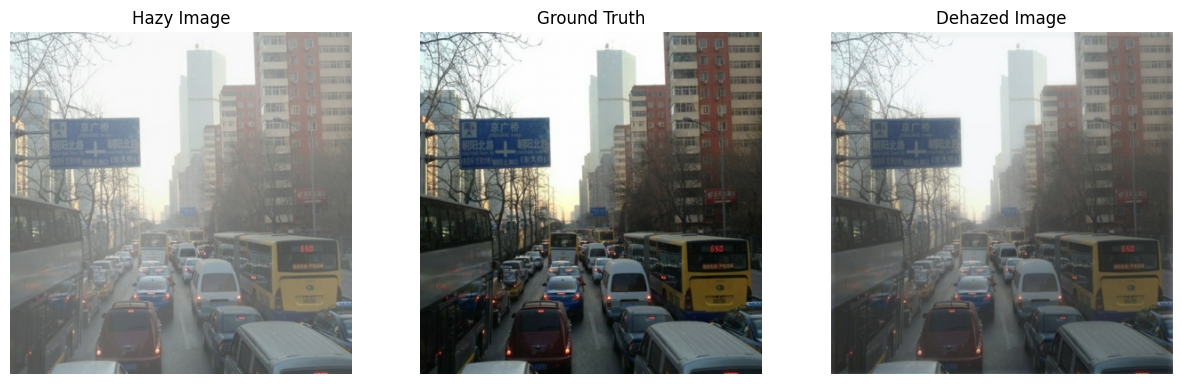

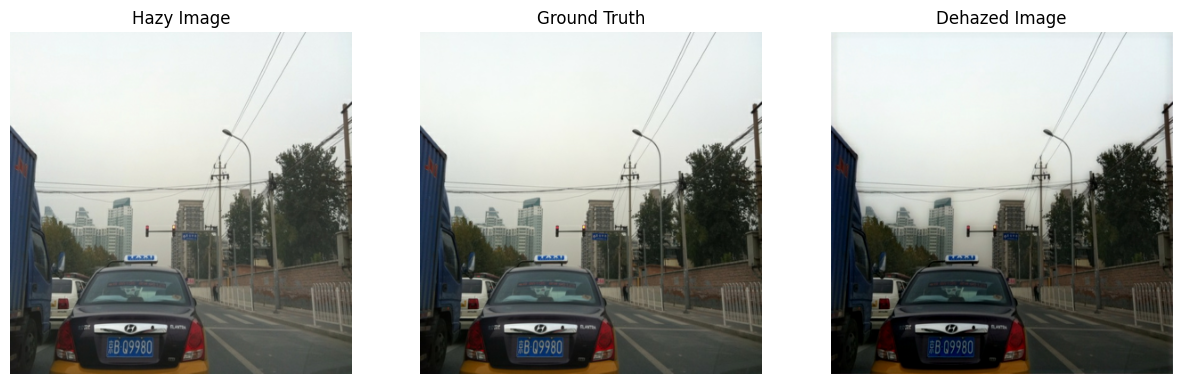

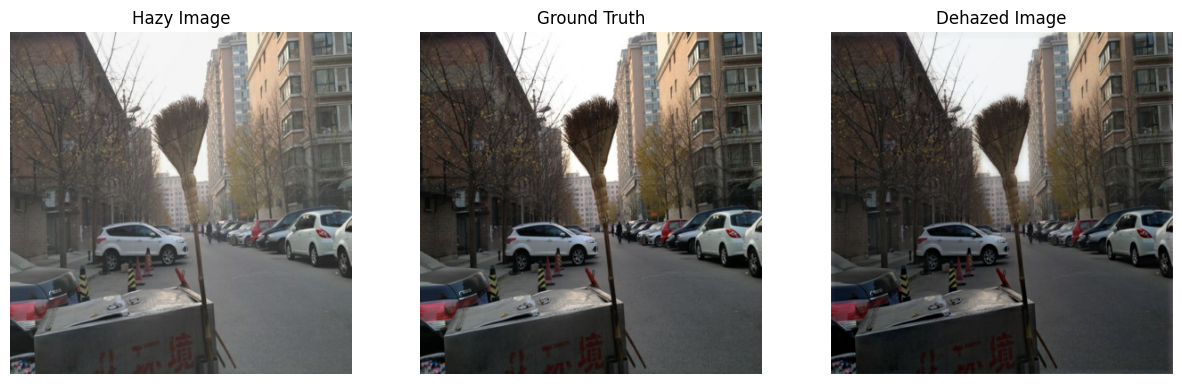

  -  Validation Loss: 0.0076  -   Time taken: 1892.23s
CPU times: user 9min 53s, sys: 1min 24s, total: 11min 18s
Wall time: 31min 36s


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [6]:
def evaluate(net, test_img_path, save_path):
    test_img = glob.glob(test_img_path + '/*.jpg')
    random.shuffle(test_img)
    output_images = []

    for idx, img_path in enumerate(test_img):

        img = tf.io.read_file(img_path)
        img = tf.io.decode_jpeg(img, channels=3)

        if img.shape[1] > img.shape[0]:
            img = tf.image.resize(img, size=(384, 384), antialias=True)
        if img.shape[1] < img.shape[0]:
            img = tf.image.resize(img, size=(384, 384), antialias=True)

        img = img / 255
        img = tf.expand_dims(img, axis=0)  # transform input image from 3D to 4D

        dehaze = net(img, training=False)
        dehaze_image = tf.keras.preprocessing.image.array_to_img(dehaze[0])

        # Extract filename from input image path
        filename = os.path.basename(img_path)
        prefix = filename[:4]
        output_filename = f"{prefix}_dehazed"  # Use the same filename for output image

        # Save the dehazed image with the same filename
        save_file_path = os.path.join(save_path, output_filename)
        dehaze_image.save(save_file_path, format='JPEG')

        # Append the saved image path to the list
        output_images.append(save_file_path)
        plt.figure(figsize=(80, 80))

        display_list = [img[0], dehaze[0]]  # make the first dimension zero
        title = ['Hazy Image', 'Dehazed Image']

        for i in range(2):
            plt.subplot(1, 2, i + 1)
            plt.title(title[i], fontsize=65, y=1.045)
            plt.imshow(display_list[i])
            plt.axis('off')

        plt.show()

    return output_images





# def evaluate(net, test_img_path, save_path):
#     test_img = glob.glob(test_img_path + '/*.jpg') + glob.glob(test_img_path + '/*.png')
#     random.shuffle(test_img)
#     output_images = []

#     for idx, img_path in enumerate(test_img):
#         img = tf.io.read_file(img_path)
#         img = tf.io.decode_image(img, channels=3)

#         if img.shape[1] > img.shape[0]:
#             img = tf.image.resize(img, size=(384, 384), antialias=True)
#         if img.shape[1] < img.shape[0]:
#             img = tf.image.resize(img, size=(384, 384), antialias=True)

#         img = img / 255
#         img = tf.expand_dims(img, axis=0)  # transform input image from 3D to 4D

#         dehaze = net(img, training=False)
#         dehaze_image = tf.keras.preprocessing.image.array_to_img(dehaze[0])

#         # Extract filename from input image path
#         filename = os.path.basename(img_path)
#         prefix = filename[:4]
#         output_filename = f"{prefix}_dehazed"  # Use the same filename for output image

#         # Save the dehazed image with the same filename
#         save_file_path = os.path.join(save_path, output_filename)
#         dehaze_image.save(save_file_path, format='JPEG' if img_path.lower().endswith('.jpg') else 'PNG')

#         # Append the saved image path to the list
#         output_images.append(save_file_path)
#         plt.figure(figsize=(80, 80))

#         display_list = [img[0], dehaze[0]]  # make the first dimension zero
#         title = ['Hazy Image', 'Dehazed Image']

#         for i in range(2):
#             plt.subplot(1, 2, i + 1)
#             plt.title(title[i], fontsize=65, y=1.045)
#             plt.imshow(display_list[i])
#             plt.axis('off')

#         plt.show()

#     return output_images


In [7]:
file_location = "/content/drive/MyDrive/Bakchodi"
test_net = tf.keras.models.load_model("/content/drive/MyDrive/trained", compile = True)
output = evaluate(test_net, r"/content/drive/MyDrive/test_hazy2",file_location)

ValueError: File format not supported: filepath=/content/drive/MyDrive/trained. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/content/drive/MyDrive/trained, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [19]:
test_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 conv2d_58 (Conv2D)          (None, 384, 384, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_59 (Conv2D)          (None, 384, 384, 64)         36928     ['conv2d_58[0][0]']           
                                                                                                  
 conv2d_60 (Conv2D)          (None, 192, 192, 128)        73856     ['conv2d_59[0][0]']           
                                                                                            

In [20]:
import cv2
test_clr_dir = "/content/drive/MyDrive/test_clear2"
test_haze_dir = "/content/drive/MyDrive/test_hazy2"
result_dir = "/content/drive/MyDrive/Bakchodi"

height, width = 384, 384

feature_test = []
label_test = []
pred_images = []

# Get the list of files in the directories
test_clr_files = os.listdir(test_clr_dir)
test_haze_files = os.listdir(test_haze_dir)
pred_images_files = os.listdir(result_dir)

# Sort the files to ensure corresponding images are matched
test_clr_files.sort()
test_haze_files.sort()
pred_images_files.sort()

# Iterate through the files and process corresponding images
for clr_file, haze_file in zip(test_clr_files, test_haze_files):
    clr_img_path = os.path.join(test_clr_dir, clr_file)
    haze_img_path = os.path.join(test_haze_dir, haze_file)

    # Load and preprocess images using OpenCV
    clr_img = cv2.imread(clr_img_path)
    haze_img = cv2.imread(haze_img_path)
    clr_img = cv2.resize(clr_img, (height, width))
    haze_img = cv2.resize(haze_img, (height, width))

    # Normalize pixel values to [0, 1] range
    clr_img = clr_img.astype('float32') / 255.0
    haze_img = haze_img.astype('float32') / 255.0

    # Append the preprocessed images to feature_test and label_test
    feature_test.append(haze_img)
    label_test.append(clr_img)

for pred_img in pred_images_files:
    pred_img_path = os.path.join(result_dir,pred_img)
    pr_img = cv2.imread(pred_img_path)
    pr_img = cv2.resize(pr_img,(height, width))
    pr_img = pr_img.astype('float32')/255.0

    pred_images.append(pr_img)


# Now you can proceed with model evaluation or any other task

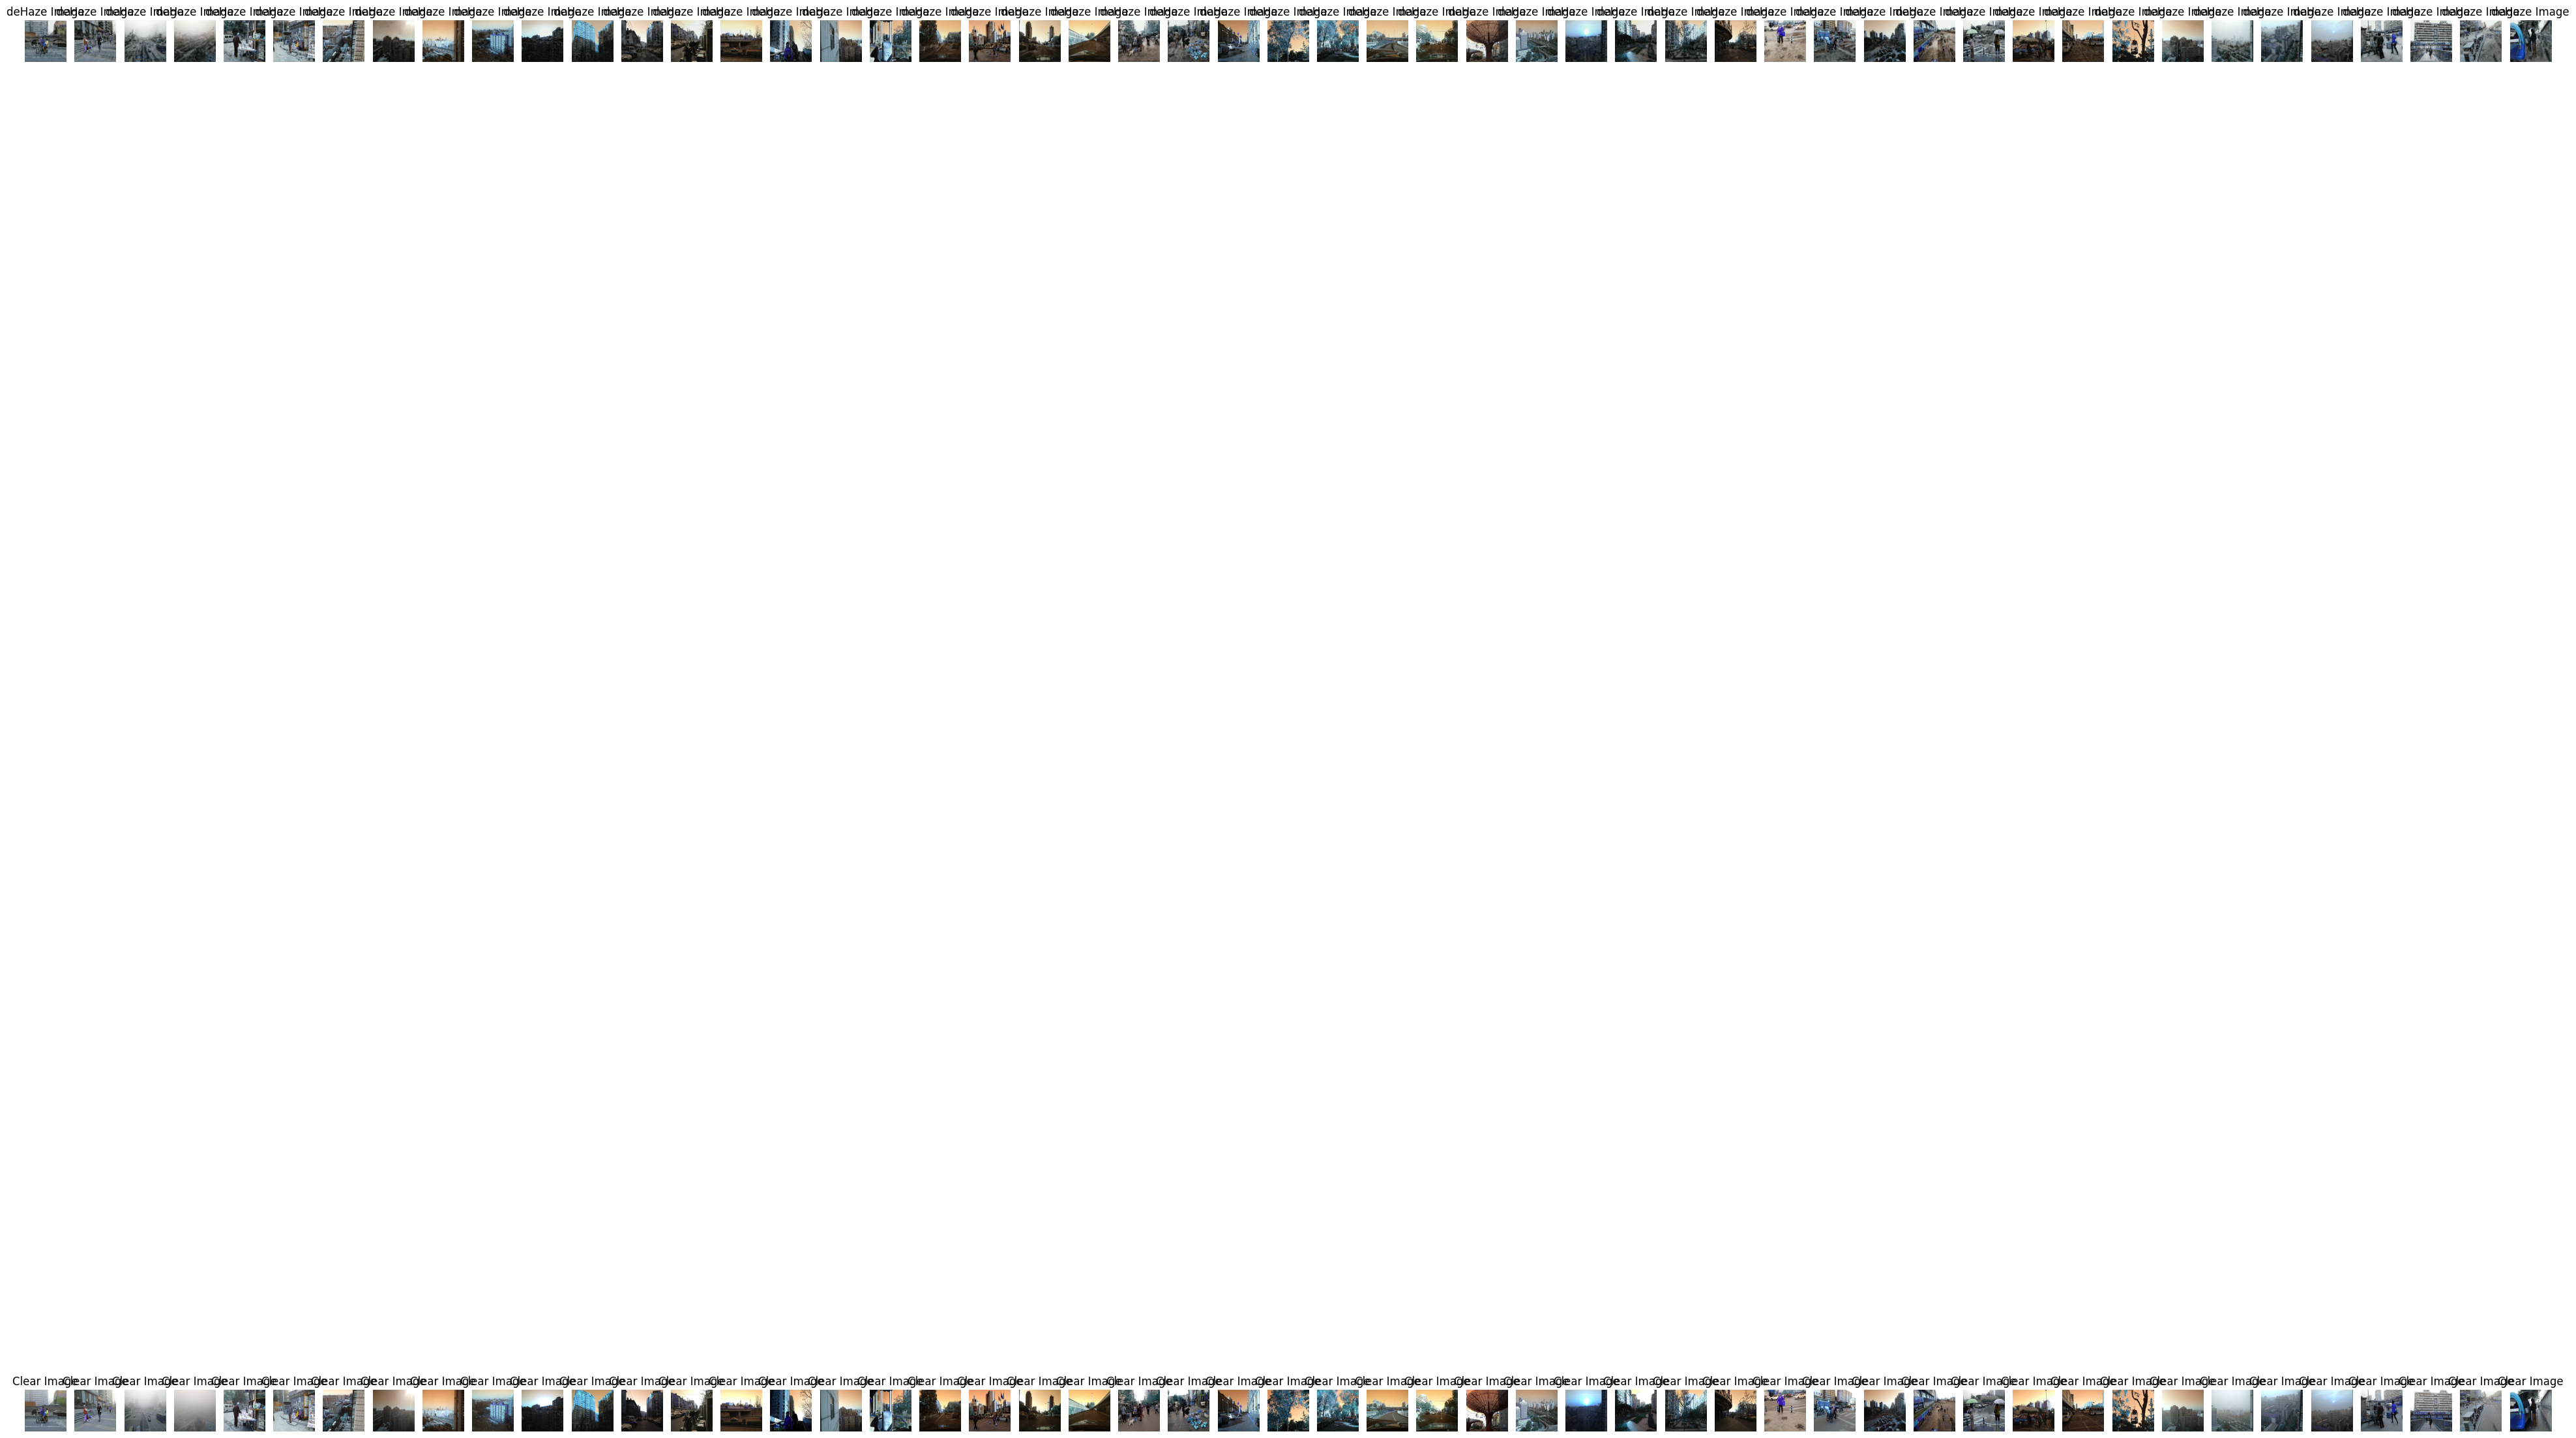

In [24]:
num_images = len(label_test)
plt.figure(figsize=(50, 50))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(pred_images[i])
    plt.title('deHaze Image')
    plt.axis('off')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(label_test[i])
    plt.title('Clear Image')
    plt.axis('off')
plt.show()


In [22]:
test_net.compile(loss = 'mean_squared_error' , optimizer = optimizer, metrics=['accuracy'])
feature_test_array = np.array(feature_test)
label_test_array = np.array(label_test)
# Reshape the arrays to match the expected input shape
# feature_test_array = np.expand_dims(feature_test_array, axis=0)  # Add batch dimension
# label_test_array = np.expand_dims(label_test_array, axis=0)  # Add batch dimension
loss, accuracy = test_net.evaluate(feature_test_array, label_test_array)
# Evaluate the model


2/2 [==============================] - 36s 14s/step - loss: 0.2700 - accuracy: 0.8483


In [28]:
ssim_scores = []
for label_image, predicted_image in zip(label_test, pred_images):
    # Ensure images have the correct shape and data type
    label_image = np.squeeze(label_image)
    predicted_image = np.squeeze(predicted_image)

    # Scale the pixel values to the appropriate range if needed
    label_image = label_image.astype(np.float32) / 255.0
    predicted_image = predicted_image.astype(np.float32) / 255.0

    # Calculate SSIM
    win_size = min(7, min(label_image.shape[:2]))
    channel_axis = 2  # Assuming RGB images
    score, _ = ssim(label_image, predicted_image, win_size=win_size, channel_axis=channel_axis, full=True)
    ssim_scores.append(score)
    # print(score)

# Calculate the average SSIM score
average_ssim = sum(ssim_scores) / len(ssim_scores)
print("Average SSIM Score:", average_ssim)


Average SSIM Score: 0.9997860917858049


In [36]:
psnr_scores = []

for label_image, predicted_image in zip(label_test, pred_images):
    # Convert images to uint8 format (0-255) for PSNR calculation
    label_image = (label_image * 255).astype(np.uint8)
    predicted_image = (predicted_image * 255).astype(np.uint8)

    # Calculate PSNR between the two images
    psnr_value = peak_signal_noise_ratio(label_image, predicted_image)
    psnr_scores.append(psnr_value)

# Calculate the average PSNR score
average_psnr = np.mean(psnr_scores)
print("Average PSNR Score:", average_psnr)


Average PSNR Score: 22.93589837481933


In [32]:
def uiqi(img1, img2):
    # Calculate mean values
    mean1 = np.mean(img1)
    mean2 = np.mean(img2)

    # Calculate variances
    var1 = np.var(img1)
    var2 = np.var(img2)

    # Calculate covariance
    cov = np.mean((img1 - mean1) * (img2 - mean2))

    # Calculate SSIM
    ssim = (2 * mean1 * mean2 + 0.01) * (2 * cov + 0.03) / ((mean1 ** 2 + mean2 ** 2 + 0.01) * (var1 + var2 + 0.03))

    return ssim


In [33]:
uiqi_scores = []
for label_image, predicted_image in zip(label_test, pred_images):
    score = uiqi(label_image, predicted_image)
    uiqi_scores.append(score)

average_uiqi = np.mean(uiqi_scores)
print("Average UIQI Score:", average_uiqi)

Average UIQI Score: 0.9604744464323427
